In [38]:
# min desired return, point on Efficient Frontier to seek, too low too little risk, too high quirky funds and weightings
MIN_RETURN = 0.145
MAX_RETURN = 0.999

MIN_ALLOCATION = 0.00
MAX_ALLOCATION = 0.13

# Risk free rate for Sharpe Ratio calculation
RISK_FREE_RATE = 0.04
PRICES_WEEKS = 365*6/7
MONTE_CARLO_ITERATIONS = 250000


In [39]:
import pandas as pd
import numpy as np

from FundSelection import FundSelection
from Portfolio import Portfolio

fund_selection = [
    # 4PHUXACGHE
    FundSelection('Ranmore Global Equity Investor GBP'), #, 0.13),
    FundSelection('L&G Global 100 Index I Acc'),
    FundSelection('MFS Meridian Contrarian Value W1 GBP'), #, 0.11),
    FundSelection('FAST - Global Fund Y-PF-ACC-GBP'),
    FundSelection('YFS Argonaut Absolute Return I GBP Acc'), #,0.12),
    #FundSelection('BH Macro GBP Ord'),
    FundSelection('WisdomTree Physical Gold GBP Daily Hdgd', 0.1),
    #FundSelection('Winton Trend Enh Glbl Eq UCITSIGBPUnHAcc'),
    #FundSelection('iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP'),
    FundSelection('JupiterMerian Glb Eq AbsRt I £ H Acc', 0.1),
    FundSelection('Prem Miton Tellworth UK Sel Fd - Cl AAcc'),
    
    # Additional
    FundSelection('Orbis OEIC Global Balanced Standard', 0.12), 
    FundSelection('JPM Europe Equity Absolute Alpha C (perf) (dist) - GBP (hedged)'), #, 0.09), #  0.1),
    FundSelection('Man High Yield Opports Profl Acc C'), #,0.1), 

    # Manual funds
    #FundSelection('Orbis OEIC Global Balanced Standard'), #, 0.1),
    #FundSelection('Ranmore Global Equity Investor GBP'), #, 0.1), 
    #FundSelection('MFS Meridian Contrarian Value W1 GBP'), #, 0.05), 
    #FundSelection('Winton Trend Enh Glbl Eq UCITSIGBPUnHAcc',0.05)   # new fund
    #FundSelection('Man Dynamic Income I H GBP Cap', None), # 0.1),   # 3 years of data

    # High Sharpe * return squared
    #FundSelection('Jupiter Global Value Equity Instl Acc'),
    #FundSelection('UBS FTSE RAFI Developed 1000 Index C Acc'),
    #FundSelection('Artemis Global Income I Acc'),
    FundSelection('Artemis SmartGARP Glb EM Eq I Acc GBP'),


    # Dynamic funds
    #FundSelection('JupiterMerian Glb Eq AbsRt I £ H Acc', None), #  0.1),
    
    
    #FundSelection('Man Sterling Corp Bd Profl Acc C', None),
    
    # Uncorrelated funds
    #FundSelection('Polar Capital Global Ins I Acc'),
    
      #FundSelection('iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP'),

    # Value

    #FundSelection('Winton Trend Enh Glbl Eq UCITSIGBPUnHAcc'), # lacks psuedo pricing data?
    #'WisdomTree Glb Efficient Cor ETFUSDAcc GBP', # Has bad numbers
    
    # 'Man Dynamic Income I H GBP Cap', - nothing correlated, only started in 2023
]

# 4PHUXACHE - 12/08/2025
benchmark = [
    FundSelection('Ranmore Global Equity Investor GBP', 0.25),
    FundSelection('L&G Global 100 Index I Acc', 0.13),
    FundSelection('MFS Meridian Contrarian Value W1 GBP', 0.06),
    FundSelection('FAST - Global Fund Y-PF-ACC-GBP', 0.06),
    FundSelection('YFS Argonaut Absolute Return I GBP Acc', 0.10),
    FundSelection('BH Macro GBP Ord', 0.10),
    FundSelection('WisdomTree Physical Gold GBP Daily Hdgd', 0.10),
    FundSelection('Winton Trend UCITS I GBP Acc', 0.05),
    FundSelection('iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP',0.05),
    FundSelection('JupiterMerian Glb Eq AbsRt I £ H Acc', 0.05),
    FundSelection('Prem Miton Tellworth UK Sel Fd - Cl AAcc', 0.05)
]

portfolio = Portfolio(fund_selection, benchmark, PRICES_WEEKS)

min_date, max_date = portfolio.get_min_max_dates(PRICES_WEEKS)

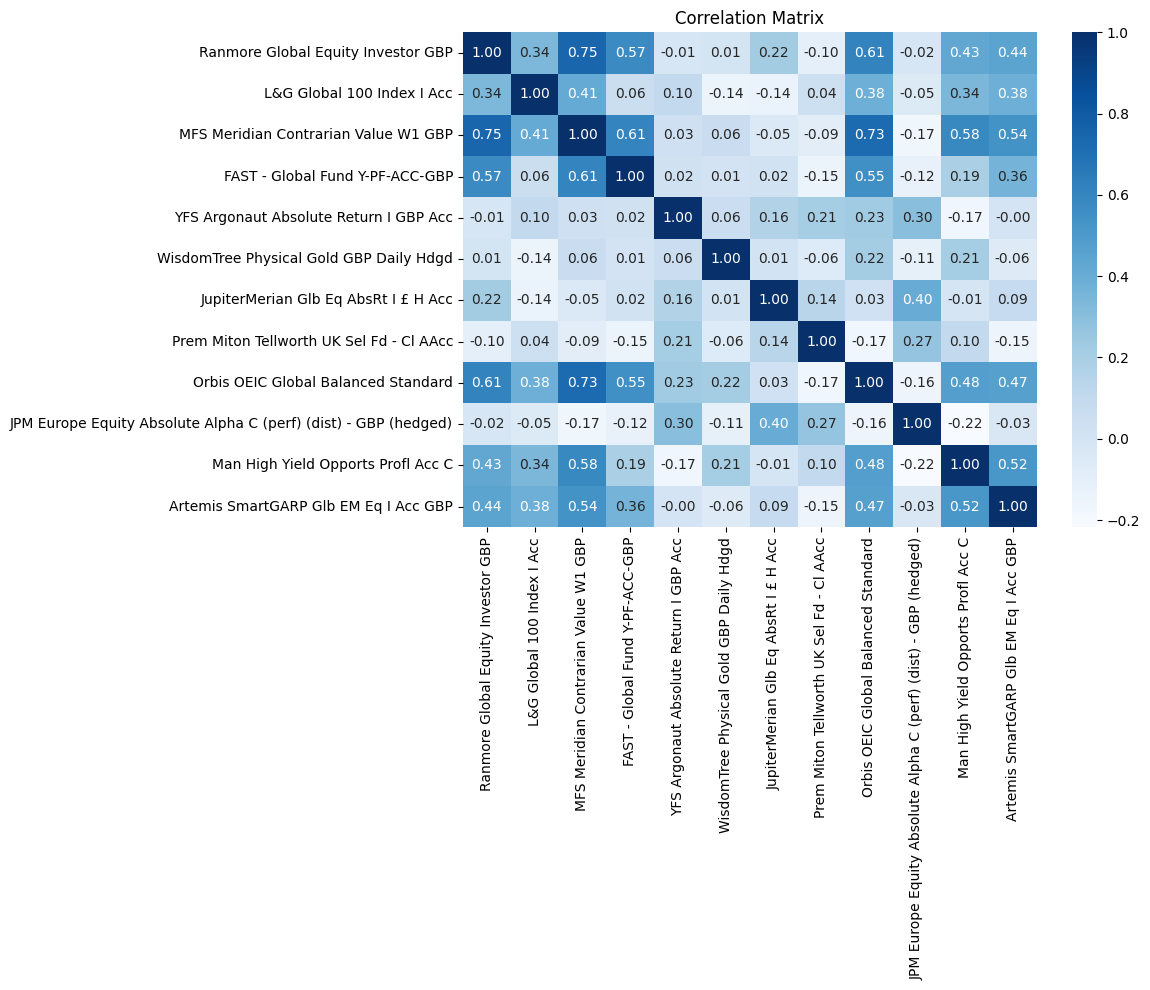

In [40]:
# Calculation Correlation Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(portfolio.correlation_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

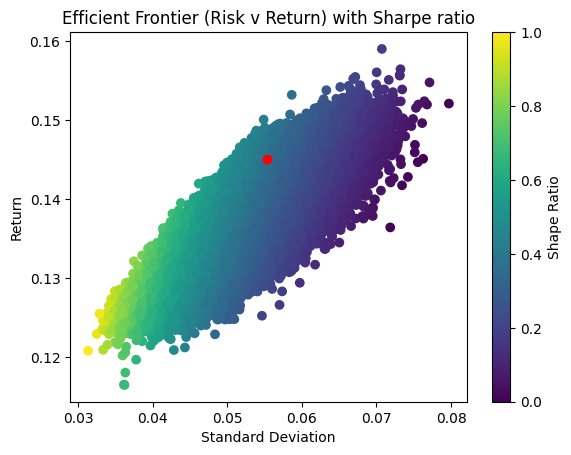

In [41]:
import matplotlib.pyplot as plt

from MonteCarlo import MonteCarlo

monte_carlo = MonteCarlo(portfolio, MIN_RETURN, MAX_RETURN, MIN_ALLOCATION, MAX_ALLOCATION)
results = monte_carlo.run(MONTE_CARLO_ITERATIONS, RISK_FREE_RATE)
stds = [result.standard_deviation for result in results]
returns = [result.annual_return for result in results]
best_result = monte_carlo.best_result(results)

if(best_result == None):
    print("No matching portfolio found")    
else:
    plt.scatter(stds, returns, c = np.array(returns) / np.array(stds))
    plt.scatter(best_result.standard_deviation, best_result.annual_return, c = "red")
    plt.colorbar(label = "Shape Ratio")
    plt.title("Efficient Frontier (Risk v Return) with Sharpe ratio")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Return")
    plt.show()

In [42]:
import plotly.express as plot
import random

if(best_result == None):
    print("No portfolio found")
else:
    weights = best_result.weights
    graph_prices = portfolio.get_daily_price_history(min_date, max_date)
    names_with_weights = []
    weight_colours=[]

    for i in range(len(graph_prices.columns)):
        percentage = weights[i]*100.0
        names_with_weights.append(f"{round(percentage,2)}% - {portfolio.fund_selection[i].name}")

        red = 40+int(random.random() * 70)
        green = 40+int(random.random() * 70)
        blue = 40+int(random.random() * 70)

        colour = f"rgb({red},{green},{blue})"  

        weight_colours.append(colour)

    # Add total to graph
    #print(graph_prices.dot(weights))
    graph_prices['Highest Sharpe Ratio portfolio'] = graph_prices.dot(weights)
    names_with_weights.append(f'Highest Sharpe Ratio portfolio for {best_result.annual_return*100.0:.2f}% return')
    weight_colours.append("yellow")

    # Add benchmark to graph
    benchmark_prices = portfolio.get_benchmark_daily_price_history(min_date, max_date)
    graph_prices['Benchmark (4PHUXACHE)'] = benchmark_prices
    names_with_weights.append(f'Benchmark (4PHUXACHE)')
    weight_colours.append("orange")

    graph_prices.columns = names_with_weights

    fig = plot.line(graph_prices, x=graph_prices.index, y=graph_prices.columns, 
                    title=f"Highest Sharpe Ratio ({round(best_result.sharpe_ratio,3)}) portfolio for {best_result.annual_return*100.0:.2f}% annualised return, min {MIN_ALLOCATION*100.0:.1f}% allocation, max {MAX_ALLOCATION*100.0:.1f}% allocation",
                    labels={'value': 'Price', 'variable': 'Instrument'},
                    template='plotly_dark',
                    color_discrete_sequence=weight_colours
                    )
    fig.update_layout(autosize=False, width=1600, height=800 )
    fig.show()


In [43]:

import numpy


results = pd.DataFrame()
	
query = f"""select 
	name, 
	InstrumentType, 
	IMASectorName as Sector, 
	Comment,
	ISIN, 
	'https://uk.finance.yahoo.com/quote/' + y_symbol as Yahoo, 
	'http://ajbell.co.uk/market-research/' + MarketCode as AjBell,
	StockLong,
	StockShort,
	BondLong,
	BondShort, 
	CashLong,
	CashShort,
	PERatio,
	RatioUnitedStates,
	RatioTechnology,
	OngoingCharge,
	Correlation,
	MaxDrawdown,
	YR_ReturnM12_5 as '2020',
	YR_ReturnM12_4 as '2021',
	YR_ReturnM12_3 as '2022',
	YR_ReturnM12_2 as '2023',
	YR_ReturnM12_1 as '2024'
from 
	dbo.Instrument 
where 
	name in ({portfolio.NamesCsv()})"""

with engine.connect() as connection:
	results = pd.read_sql_query(query, connection)

for i in range(len(results["name"])):
	name = results["name"].loc[i]
	print(name)

	print(portfolio.Weight(name))
	#offset = numpy.where(funds[i].name == x)
	#print(offset)		
	#print(name)


AttributeError: 'Portfolio' object has no attribute 'NamesCsv'